Secure Data Vault (SDV)
==========

This notebook is used to test drive **SDV**, an open source library from MIT for generating synthetic data.

Data Set
------------------

[Lending Club loan data set](https://www.kaggle.com/wordsforthewise/lending-club).  I like this data set due to its size and high dimensionality.  The data inside is also pretty raw with many columns containing null values which provides us an opportunity to do some data prep/cleansing - just like in any real-world situation.

Many of SDV's models are computationally intensive and will overwhelm most general-purpose VM instances (e.g. Azure's Dv4-series).  I've created a utility called [randomSampler.py](./randomSampler.py) to help reduce the data set to a more manageable size for your personal equipment.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

## Load and prep data set

In [2]:
original_df = pd.read_csv('./500_accepted_2007_2018Q4.csv', low_memory=False)
original_df.shape

(500, 151)

Create a copy of the original dataframe.  We'll play with the copy to avoid having to reload the original dataset from disk later.


In [11]:
df = original_df.copy(deep=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,67398322,NaN,21000.0,21000.0,21000.0,36 months,8.49,662.83,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68102522,NaN,24000.0,24000.0,24000.0,36 months,9.80,772.17,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,67357364,NaN,26000.0,26000.0,26000.0,36 months,13.67,884.46,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,67215673,NaN,26000.0,26000.0,26000.0,36 months,7.26,805.90,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,66575072,NaN,4200.0,4200.0,4200.0,36 months,7.89,131.40,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Description for some of the columns can be found at https://www.rubydoc.info/gems/lending_club/0.0.2/LendingClub/Loan.

### Determine if there are opportunities to reduce dimensionality
Let's first see if there are any columns with missing values.

In [12]:
# Find the count and percentage of missing values
df_columns_na = pd.DataFrame({
    '% Empty': 100*df.isnull().sum()/len(df), 
    'Count': df.isnull().sum()
    })

# Determine columns with null count > 0
df_columns_na_sorted = df_columns_na[df_columns_na['Count'] > 0].sort_values('% Empty', ascending=False)
df_columns_na_sorted

,% Empty,Count
member_id,100.0,500
orig_projected_additional_accrued_interest,99.6,498
hardship_dpd,99.4,497
hardship_status,99.4,497
deferral_term,99.4,497
...,...,...
total_bal_ex_mort,2.6,13
title,0.6,3
last_pymnt_d,0.2,1
revol_util,0.2,1


In [13]:
df_columns_na_sorted.head()
print("Data set has " + str(df.shape[1]) + " columns.\n" +
    "Of which, " + str(df_columns_na_sorted.shape[0]) + " have missing values.")

Data set has 151 columns.
Of which, 98 have missing values.


In [14]:
# Drop columns with a certain threshold of missing values
threshold = 75 # % threshold
df.dropna(axis='columns', thresh=int(threshold/100*len(df)), inplace=True)
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,67398322,21000.0,21000.0,21000.0,36 months,8.49,662.83,B,B1,Sergeant,...,0.0,0.0,0.0,280975.0,14333.0,38000.0,0.0,N,Cash,N
1,68102522,24000.0,24000.0,24000.0,36 months,9.80,772.17,B,B3,Electronic Tech,...,0.0,1.0,0.0,317642.0,42297.0,37800.0,50600.0,N,Cash,N
2,67357364,26000.0,26000.0,26000.0,36 months,13.67,884.46,C,C4,Aircraft Maintenance Technician,...,50.0,0.0,0.0,390975.0,13064.0,6500.0,10475.0,N,Cash,N
3,67215673,26000.0,26000.0,26000.0,36 months,7.26,805.90,A,A4,Inventory Specialist,...,0.0,0.0,0.0,428041.0,28001.0,51800.0,63741.0,N,Cash,N
4,66575072,4200.0,4200.0,4200.0,36 months,7.89,131.40,A,A5,driver,...,0.0,0.0,0.0,43125.0,19920.0,25600.0,12925.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,91528161,32000.0,32000.0,32000.0,36 months,7.24,991.59,A,A3,Managing Partner,...,20.0,0.0,0.0,1101489.0,292219.0,108000.0,88489.0,N,Cash,N
496,91589847,17500.0,17500.0,17500.0,60 months,28.69,552.19,F,F1,School Bus Driver,...,0.0,1.0,0.0,52278.0,32580.0,2000.0,45578.0,N,Cash,N
497,92223546,25000.0,25000.0,25000.0,60 months,18.99,648.38,D,D3,Senior Director Of Customer Experience,...,100.0,0.0,0.0,51095.0,28828.0,18600.0,17995.0,N,Cash,N
498,91583656,3000.0,3000.0,3000.0,36 months,8.99,95.39,B,B1,president,...,50.0,0.0,0.0,104400.0,11633.0,8900.0,0.0,N,Cash,N


### Distribution of data types

Text(0, 0.5, 'Data type')

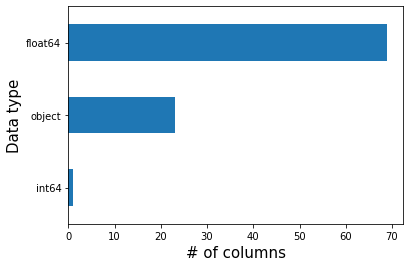

In [15]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.xlabel('# of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

In [16]:
# Check amount of categorical data for columns with object datatype
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                      2
grade                     7
sub_grade                31
emp_title               408
emp_length               11
home_ownership            3
verification_status       3
issue_d                  86
loan_status               7
pymnt_plan                1
url                     500
purpose                  12
title                    50
zip_code                292
addr_state               47
earliest_cr_line        244
initial_list_status       2
last_pymnt_d             65
last_credit_pull_d       43
application_type          2
hardship_flag             1
disbursement_method       2
debt_settlement_flag      2
dtype: int64

In [17]:
# Inspect a few columns

df['emp_length'].unique()
#df['purpose'].unique()
#df['grade'].unique()
#df['sub_grade'].unique()
#df['last_credit_pull_d'].unique()
#df['term'].unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '5 years',
       '6 years', '9 years', '2 years', '1 year', '4 years', nan,
       '7 years'], dtype=object)

In [18]:
# Remove string characters in 'term' column
df['term'] = df['term'].map(lambda x: x.lstrip(' ').rstrip('months'))

Text(0, 0.5, '# of loans')

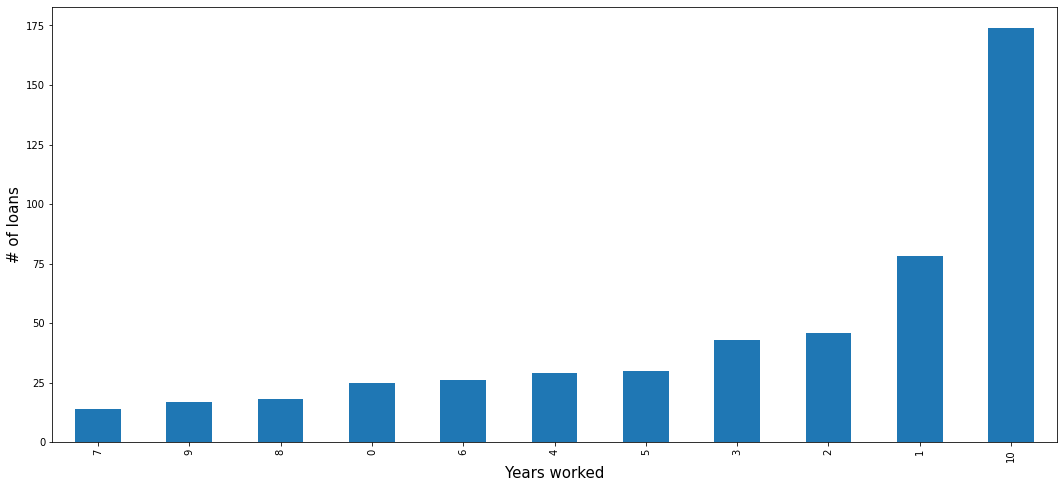

In [19]:
# Recode emp_length column: fill empty fields with 0, remove any text, 10+ yrs gets coded as 10.
df['emp_length'].fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', regex=True, inplace=True)

df['emp_length'].value_counts().sort_values().plot(kind='bar',figsize=(18,8))
plt.xlabel('Years worked',fontsize=15);
plt.ylabel('# of loans',fontsize=15)

In [20]:
# Remove string characters in 'zipcode' column
df['zip_code'] = df['zip_code'].str.replace(r'\D', '')

In [21]:
# Change datatypes to INTs in the following columns
df.term = df.term.astype("int64") 
df.emp_length = df.emp_length.astype("int64") 
df.zip_code = df.zip_code.astype("int64")

In [22]:
# Create a new dataframe for exploration and drop unnecessary column(s) 
df_eda = df.drop(['url'], axis=1)
df_eda.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,67398322,21000.0,21000.0,21000.0,36,8.49,662.83,B,B1,Sergeant,...,0.0,0.0,0.0,280975.0,14333.0,38000.0,0.0,N,Cash,N
1,68102522,24000.0,24000.0,24000.0,36,9.80,772.17,B,B3,Electronic Tech,...,0.0,1.0,0.0,317642.0,42297.0,37800.0,50600.0,N,Cash,N
2,67357364,26000.0,26000.0,26000.0,36,13.67,884.46,C,C4,Aircraft Maintenance Technician,...,50.0,0.0,0.0,390975.0,13064.0,6500.0,10475.0,N,Cash,N
3,67215673,26000.0,26000.0,26000.0,36,7.26,805.90,A,A4,Inventory Specialist,...,0.0,0.0,0.0,428041.0,28001.0,51800.0,63741.0,N,Cash,N
4,66575072,4200.0,4200.0,4200.0,36,7.89,131.40,A,A5,driver,...,0.0,0.0,0.0,43125.0,19920.0,25600.0,12925.0,N,Cash,N


## Exploratory data analysis

SDV GaussianCopula
--------------------------


In [15]:
from sdv.tabular import GaussianCopula

copula_model = GaussianCopula()
copula_model.fit(df)

In [ ]:
copula_model.save('lending_club_copula_model.pkl')

In [ ]:
loaded_model = GaussianCopula.load('lending_club_copula_model.pkl')

### Generate synthetic data from model

In [16]:
synthetic_data = copula_model.sample(200)

In [17]:
synthetic_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,63934077,NaN,6917.090478,7431.013537,7440.417082,36 months,14.146686,266.444437,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,62223791,NaN,3126.766591,3218.898829,3148.941281,36 months,25.149506,87.838224,B,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,34195192,NaN,6831.773089,7233.606526,6772.272787,36 months,16.510359,270.105475,E,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,171265080,NaN,8467.200829,8174.217091,8424.713262,36 months,10.155162,305.300025,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,81230441,NaN,20641.881174,20757.326497,20659.329426,36 months,9.752449,565.814135,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
